In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri

In [2]:
df_final = pd.read_pickle("df_final.pkl")

In [3]:
df_final.head()

,Salemonth,ORGPRICE,AMT,amt_diff,retail_diff,BRAND_dummy_Affordable,BRAND_dummy_Luxury,ReturnRate,Returns
0,1,30.0,0.0,-30.0,410.0,1,0,0.075151,0
1,1,30.0,0.0,-30.0,410.0,1,0,0.075151,1
2,7,6.0,6.0,0.0,-3.0,0,0,0.075151,0
3,6,6.0,6.0,0.0,-3.0,0,0,0.075151,0
4,7,6.0,6.0,0.0,-3.0,0,0,0.075151,0


In [4]:
from sklearn.model_selection import train_test_split

# Split the dataset into 80% training and 20% testing
train_set, test_set = train_test_split(df_final, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print("Training set shape:", train_set.shape)
print("Testing set shape:", test_set.shape)

Training set shape: (46994555, 9)
Testing set shape: (11748639, 9)


In [5]:
# Separate features (X) and target variable (y)
X_test = test_set.drop('Returns', axis=1)
y_test = test_set['Returns']

In [6]:
# Randomly select 15,000 samples where Returns == 0
returns_0_samples = train_set[train_set['Returns'] == 0].sample(n=15000, random_state=42)

# Randomly select 15 samples where Returns == 1
returns_1_samples = train_set[train_set['Returns'] == 1].sample(n=15000, random_state=42)

# Concatenate the two samples
train_new = pd.concat([returns_0_samples, returns_1_samples])

# Display the selected samples
print(train_new)


         Salemonth  ORGPRICE   AMT  amt_diff  retail_diff  \
39980653         2      48.0  48.0       0.0       -36.00   
56214121        12      17.5  13.5      -4.0        -4.00   
29789557         1      14.5  13.5      -1.0        -0.50   
9953600          6      39.5  39.5       0.0       -19.75   
48380587         3      14.0  13.5      -0.5         0.00   
...            ...       ...   ...       ...          ...   
16720044         2      24.0  22.0      -2.0         0.00   
5792351          7      98.0  98.0       0.0       -73.50   
20421427         5      29.5  29.5       0.0         0.00   
50982336         3      20.0   6.0     -14.0       -18.50   
12045828        11      69.0  59.0     -10.0       -39.50   

          BRAND_dummy_Affordable  BRAND_dummy_Luxury  ReturnRate  Returns  
39980653                       1                   0    0.081596        0  
56214121                       0                   0    0.073429        0  
29789557                       0       

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from collections import Counter
import pickle

In [8]:
# Check if every column has all NaN values
nan_check_all = train_new.isnull().all()

# Display the result
print("Columns with all NaN values:")
print(nan_check_all)

Columns with all NaN values:
Salemonth                 False
ORGPRICE                  False
AMT                       False
amt_diff                  False
retail_diff               False
BRAND_dummy_Affordable    False
BRAND_dummy_Luxury        False
ReturnRate                False
Returns                   False
dtype: bool


In [9]:
# Separate features (X) and target variable (y)
X_train = train_new.drop('Returns', axis=1)
y_train = train_new['Returns']

In [10]:
X_train.shape

(30000, 8)

In [11]:
fit1 =LogisticRegression()
fit1.fit(X_train,y_train)

# Display the summary
print("Intercept:", fit1.intercept_)
print('Coefficients:', fit1.coef_)

Intercept: [-0.63271198]
Coefficients: [[ 0.00629065 -0.00217032  0.00484841  0.00701872 -0.00387496  0.55052183
   0.61727466 -0.03928453]]


In [12]:
# Make predictions on the resampled test data
pred1 = fit1.predict(X_test)

# Evaluate the model on the resampled training data
accuracy_resampled = accuracy_score(y_test, pred1)
conf_matrix_resampled = confusion_matrix(y_test, pred1)
classification_rep_resampled = classification_report(y_test, pred1)

# Print the evaluation metrics on the resampled training data
print("Accuracy on Test Data:", accuracy_resampled)
print("Confusion Matrix on Test Data:\n", conf_matrix_resampled)
print("Classification Report on Test Data:\n", classification_rep_resampled)

Accuracy on Test Data: 0.44680307225373084
Confusion Matrix on Test Data:
 [[4587375 6276071]
 [ 223240  661953]]
Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.95      0.42      0.59  10863446
           1       0.10      0.75      0.17    885193

    accuracy                           0.45  11748639
   macro avg       0.52      0.59      0.38  11748639
weighted avg       0.89      0.45      0.55  11748639



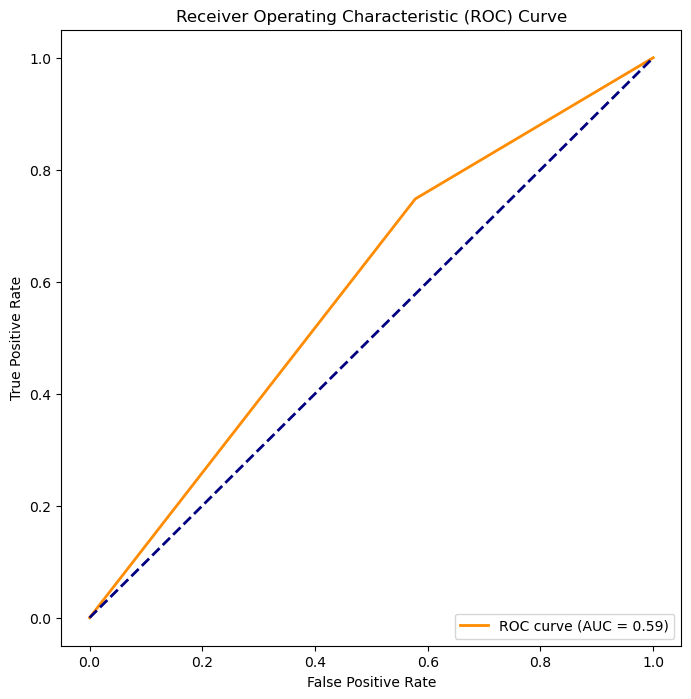

In [13]:
## ROC curve 

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pred1)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()